In [2]:
import sys
sys.path.append("..")

from wishart import wishart_lib, wishart_lib_stepan
from indexes import indexes_lib
from generator import generator_lib
import numpy as np
from matplotlib import pyplot as plt
import importlib

import sys
sys.path.append("..")
importlib.reload(wishart_lib_stepan)
importlib.reload(wishart_lib)
importlib.reload(indexes_lib)
importlib.reload(generator_lib)

<module 'generator.generator_lib' from '/home/mrplotva/time_series/generator/generator_lib.py'>

In [3]:
import math
from itertools import product
import numpy as np
from tabulate import tabulate


def center(data):
    n = data.shape[0]
    m = data.shape[1]
    summ = np.zeros(m)
    for i in range(n):
        summ += data[i]
    summ /= np.array([n for i in range(m)])
    return summ


def dist(x, y):
    diff = x - y
    return np.sqrt(sum(diff ** 2))


def math_norm(x):
    x = np.array([x])
    return np.sqrt((x @ x.T)[0, 0])


def cleaning(data, cluster):
    # cleans all zeros!!
    clean_data = []
    clean_cluster = []
    was = dict()
    for i in range(data.shape[0]):
        if cluster[i] == 0:
            continue
        if cluster[i] not in was:
            was[cluster[i]] = len(was)
        clean_data.append(data[i])
        clean_cluster.append(was[cluster[i]])

    return np.array(clean_data), clean_cluster


class MeasureIndexes:
    def __init__(self, data, cluster):
        data, cluster = cleaning(data, cluster)
        # data = data set, cluster[i] = cluster of i-th point
        self.data = data  # data set
        self.N = data.shape[0]  # number of object in data set
        self.center = center(data)  # center of data set
        self.cluster = cluster  # cluster[i] = cluster of i-th point
        self.P = 0  # ???
        self.NC = max(cluster) + 1  # cnt clusters

        self.C = []  # C[i] - i-th cluster
        for i in range(self.NC):
            self.C.append([])
        for i in range(self.N):
            self.C[cluster[i]].append(data[i])
        for i in range(self.NC):
            self.C[i] = np.array(self.C[i])

        self.n = [0] * self.NC  # n[i] - len of i-th cluster
        for i in range(self.NC):
            self.n[i] = len(self.C[i])

        self.c = [0] * self.NC  # c[i] - center of i-th cluster
        for i in range(self.NC):
            self.c[i] = center(self.C[i])

    def RS(self):
        s1 = 0
        s2 = 0
        for x in self.data:
            s1 += math_norm(x - self.center) ** 2

        for i in range(self.NC):
            for x in self.C[i]:
                s2 += math_norm(x - self.c[i]) ** 2

        return (s1 - s2) / s1

    def G(self):
        s = 0
        for i in range(self.N):
            for j in range(self.N):
                x = self.data[i]
                y = self.data[j]
                ci = self.cluster[i]
                cj = self.cluster[j]
                s += dist(x, y) * dist(self.c[ci], self.c[cj])

        return (2 * s) / (self.N * (self.N - 1))

    def CH(self):
        s1 = 0
        for i in range(self.NC):
            s1 += self.n[i] * (dist(self.c[i], self.center) ** 2)
        s1 /= self.NC - 1

        s2 = 0
        for i in range(self.NC):
            for x in self.C[i]:
                s2 += dist(x, self.c[i]) ** 2
        s2 /= self.N - self.NC

        return s1 / s2

    def D(self):
        max_d = 0
        for k in range(self.NC):
            for x, y in product(self.C[k], self.C[k]):
                max_d = max(max_d, dist(x, y))

        min_d = 10 ** 10
        for i in range(self.NC):
            for j in range(self.NC):
                if i == j:
                    continue
                for x, y in product(self.C[i], self.C[j]):
                    min_d = min(min_d, dist(x, y))

        return min_d / max_d

    def S(self):
        s = 0
        for i in range(self.NC):
            cur = 0
            for x in self.C[i]:
                ax = 0
                for y in self.C[i]:
                    ax += dist(x, y)
                if self.n[i] > 1:
                    ax /= self.n[i] - 1

                bx = 10 ** 20
                for j in range(self.NC):
                    if i == j:
                        continue
                    res = 0
                    for y in self.C[j]:
                        res += dist(x, y)
                    res /= self.n[j]
                    bx = min(bx, res)
                cur += (bx - ax) / max(bx, ax)
            s += cur / self.n[i]

        return s / self.NC

    def DB(self):
        res = 0
        for i in range(self.NC):
            mx = 0
            for j in range(self.NC):
                if j == i:
                    continue
                s1 = 0
                for x in self.C[i]:
                    s1 += dist(x, self.c[i])
                s1 /= self.n[i]

                s2 = 0
                for x in self.C[j]:
                    s2 += dist(x, self.c[j])
                s2 /= self.n[j]

                s = (s1 + s2) / dist(self.c[i], self.c[j])
                mx = max(mx, s)
            res += mx
        return res / self.NC

    def XB(self):
        s1 = 0
        for i in range(self.NC):
            for x in self.C[i]:
                s1 += dist(x, self.c[i]) ** 2
        s2 = 10 ** 20
        for i in range(self.NC):
            for j in range(self.NC):
                if i == j:
                    continue
                s2 = min(s2, dist(self.c[i], self.c[j]) ** 2)

        s2 *= self.N

        return s1 / s2

    def Calculate(self):
        res = dict()
        # res["RS"] = self.RS()
        # res["G"] = self.G()
        res["CH"] = self.CH()
        res["D"] = self.D()
        res["S"] = self.S()
        res["DB"] = self.DB()
        res["XB"] = self.XB()

        return res


index_list = ["CH", "D", "S", "DB", "XB"]


class Tester:
    def __init__(self):
        self.results = []

    def add_test(self, data, cluster):
        calculator = MeasureIndexes(data, cluster)
        res = calculator.Calculate()
        res["id"] = len(self.results) + 1
        self.results.append(res)


    def display(self):
        col_names = ["id"] + index_list
        data = []

        for i in range(len(self.results)):
            row = [round(self.results[i][key], 3) for key in col_names]
            data.append(row)

        for i in range(1, len(data[0])):
            max_val = data[0][i]
            min_val = data[0][i]
            for j in range(len(data)):
                max_val = max(max_val, data[j][i])
                min_val = min(max_val, data[j][i])

            target_val = max_val
            if col_names[i] == "DB" or col_names[i] == "XB":
                target_val = min_val

            for j in range(len(data)):
                if target_val == data[j][i]:
                    data[j][i] = '\033[36m' + str(data[j][i]) + '\033[0m'


        print(tabulate(data, headers=col_names))



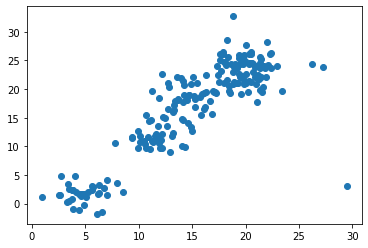

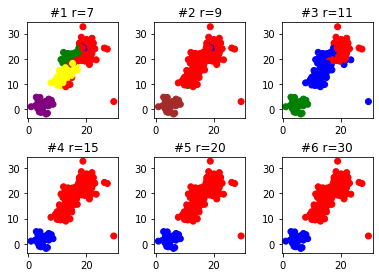

  id       CH      D      S     DB     XB
----  -------  -----  -----  -----  -----
   1  278.995  0.003  0.325  1.251  2.8
   2  119.964  0.002  0.567  1.593  7.971
   3  532.843  0.016  0.557  0.653  0.183
   4  398.715  0.199  0.723  0.356  0.08
   5  398.715  0.199  0.723  0.356  0.08
   6  398.715  0.199  0.723  0.356  0.08


In [4]:
generator = generator_lib.Generator()
res = generator.generate_with_noise()

arr = np.array(res)
xs = arr[:, 0]
ys = arr[:, 1]
plt.scatter(xs, ys)
plt.show()

tester = Tester()

fig, axs = plt.subplots(2, 3)
ind = 0

for r in [7, 9, 11, 15, 20, 30]:
    wishart = wishart_lib.Wishart(r, 0.2)
    w = wishart.fit(arr)
    colour_pool = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'orange', 'pink', 'white', 'black', 'cyan']

    tester.add_test(arr, w)

    clean_data, clean_w = cleaning(arr, w)
    colours = [colour_pool[i] for i in clean_w]

    axs[ind // 3, ind % 3].scatter(clean_data[:, 0], clean_data[:, 1], c=colours)
    axs[ind // 3, ind % 3].set_title('#{} r={}'.format(ind+1, r))
    ind += 1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


tester.display()




In [79]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

print(color.BOLD + 'Hello, World!' + color.END)

Hello, World!
